# Problem Set 3

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt 
import time
from scipy import linalg
import statsmodels.api as sm
import copy
import warnings
warnings.filterwarnings('ignore')

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:

*NOTE - This dataset is similar to the one you used in PS1; we are just using a different method to load it this time. The column names and their order will remain the same for this dataset as was in PS1.*

In [3]:
# load Boston housing data set
data = np.loadtxt('data.txt')
target = np.loadtxt('target.txt')

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function  to compute RMSE, other than numpy functions like `sqrt` and if needed, `sum` or other relevant ones.

In [4]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((4,6,3),(2,1,4)))
3.16
"""
def compute_rmse(predictions, yvalues):
    # your code here
    if type(predictions)!=np.ndarray:
        predictions = np.array(predictions)
        
    if type(yvalues)!=np.ndarray:
        yvalues = np.array(yvalues)
    
    n = len(predictions)
    mean_squared = (predictions-yvalues)**2
    mse = np.sum(mean_squared)/n
    rmse = round(np.sqrt(mse),2)
    return rmse

In [5]:
compute_rmse((4,6,3),(2,1,4))

3.16

### 1.2 Divide your data into training and testing datasets

Randomly select 75% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 25% in a testing dataset (call this "bdata_test"). Do not use built-in functions.

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [6]:
#combining data into dataframe 
boston_data = pd.DataFrame(data)
boston_data.columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
boston_data['MEDV']= target

# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

#function for splitting data
def split_data(data, size):
    #shuffling the data randomly
    data = data.sample(frac=1).reset_index(drop=True)
    #Train Test split based on size
    test = data[: int(size*len(data))]
    train = data[int(size*len(data)):]
    return train,test

bdata_train, bdata_test = split_data(boston_data, 0.25)

bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

### 1.3 Use a very bad baseline for prediction, and compute RMSE

Let's start by creating a very bad baseline model that predicts median home values as the averages of `MEDV` based on adjacency to Charles River. 

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of all houses in the **training set** that have the same adjacency value as the observation.

For example - For an input observation where `CHAS==1`, the model should predict the `MEDV` as the mean of all `MEDV` values in the training set that also have `CHAS==1`.



Once the model is built, do the following:

1. Compute the RMSE of the training set.
2. Now compute the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in red and the test instances in blue. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?


*NOTE - Be careful while dealing with floats and integers. Additionally, the `groupby` operation might come handy here.*

In [7]:
baseline_data_chas = bdata_train[bdata_train['CHAS']==1]
baseline_mean_chas = round(np.mean(baseline_data_chas['MEDV']),5)
baseline_data_non_chas = bdata_train[bdata_train['CHAS']==0]
baseline_mean_non_chas = round(np.mean(baseline_data_non_chas['MEDV']),5)

train_data = bdata_train.copy()
test_data = bdata_test.copy()
train_data['PRED_MEDV'] = 1
test_data['PRED_MEDV'] = 1

train_data.loc[train_data.CHAS == 1, 'PRED_MEDV']= baseline_mean_chas
train_data.loc[train_data.CHAS == 0, 'PRED_MEDV']= baseline_mean_non_chas
test_data.loc[test_data.CHAS == 1, 'PRED_MEDV']= baseline_mean_chas
test_data.loc[test_data.CHAS == 0,'PRED_MEDV']= baseline_mean_non_chas

def train_test_rmse(train_labels, test_labels, train_pred_labels, test_pred_labels):
    train_data_rsme = compute_rmse(train_pred_labels, train_labels)
    time_0 = time.time()
    test_data_rsme = compute_rmse(test_pred_labels, test_labels)
    time_1 = time.time()
    total_time = time_1 - time_0
    print(f'RMSE for Training Data: {train_data_rsme}')
    print(f'RMSE for Testing Data: {test_data_rsme}')
    print(f'Time taken to compute the predicted test labels: {total_time}')
    
train_test_rmse(train_data['MEDV'], test_data['MEDV'], train_data['PRED_MEDV'], test_data['PRED_MEDV'])

RMSE for Training Data: 9.12
RMSE for Testing Data: 8.89
Time taken to compute the predicted test labels: 0.00010633468627929688


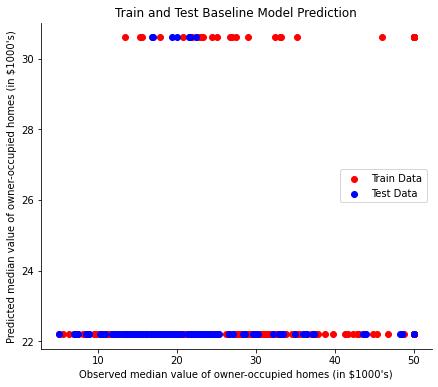

In [30]:
#Plotting
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot()
ax.scatter(train_data['MEDV'], train_data['PRED_MEDV'], label='Train Data', c='red')
ax.scatter(test_data['MEDV'], test_data['PRED_MEDV'], label= 'Test Data', c='blue')
ax.set_xlabel("Observed median value of owner-occupied homes (in $1000's)")
ax.set_ylabel("Predicted median value of owner-occupied homes (in $1000's)")
ax.set_title("Train and Test Baseline Model Prediction")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show(fig)

In [10]:
# #Mean value baseline model
# baseline_model = bdata_train['MEDV'].mean()

# #Training RMSE
# train_predictions_baseline= np.ones(len(bdata_train))*baseline_model
# train_baseline_RMSE = compute_rmse(train_predictions_baseline, bdata_train['MEDV'])
# print("Train RMSE:")
# print(train_baseline_RMSE)

# #Computing time taken for predicting on test data
# start_time = time.time()
# test_predictions_baseline = np.ones(len(bdata_test)) * baseline_model
# end_time = time.time()
# time_test_prediction = end_time - start_time
# print("Time Taken for prediction: ")
# print(time_test_prediction)

# #Test RMSE
# test_baseline_RMSE = compute_rmse(test_predictions_baseline,bdata_test['MEDV'])
# print("Test RMSE:")
# print(test_baseline_RMSE)

1. Train RMSE: 9.12

2. Test RMSE: 8.89

3. Training and Test set RMSE is comparable, in line with my expectation.

4. It took 0.0001 seconds to compute the predicted value for test set.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (2,7) and (5,11), and then compute the Manhattan distance between (4,4) and (12,10).

[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

In [12]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((2,7),(5,11),2))
5

"""
def distance(x1, x2, L):
    # your code here
    if type(x1)!=np.ndarray:
        x1 = np.array(x1)
    
    if type(x2)!=np.ndarray:
        x2 = np.array(x2)
    
            
    # L-norm distance when x2 has many points in it
    if x2.ndim!=1:
        dist = (np.sum((abs(x1 - x2))**L, axis=1))**(1/L)
        
    # L-norm distance when x2 has a single point in it
    else:
        dist = (np.sum((abs(x1 - x2))**L))**(1/L)
    return dist

print(f"The Euclidean distance between the points (2,7) and (5,11) is {distance((2,7),(5,11),2)}")
print(f"The Manhattan distance between the points (4,4) and (12,10) is {distance((4,4),(12,10),1)}")

The Euclidean distance between the points (2,7) and (5,11) is 5.0
The Manhattan distance between the points (4,4) and (12,10) is 14.0


### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use three input features (`CRIM, RM and ZN`) and a single output (`MEDV`).  In other words, you are modelling the relationship between median home value and crime rates, house size and the proportion of residential land zoned for lots.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the `MEDV` value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function. Use L=2 for all questions henceforth unless explicitly stated otherwise.

Make sure to do the following - 
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in red and the test instances in blue. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.3?

In [13]:
"""
Function
--------
Nearest Neighbors

Implementation of nearest neighbors algorithm.

Parameters
----------
x_train: array
    Array of numerical feature values for training the model.
y_train: array
    Array of numerical output values for training the model.
x_test: array
    Array of numerical feature values for testing the model.
y_test: array
    Array of numerical output values for testing the model.
L: int
    Order of L-norm function used for calculating distance.

Returns
-------
rmse : int
    Value of the RMSE from data.
"""

# 1. Fill in the function specification below
def nneighbor(X_Train,Y_Train,X_Test,Y_Test, L):
    
    start_time = time.time()
    Y_Test_predicted = np.zeros(len(X_Test))
    
    #Compute distances
    for i in range(len(X_Test)):
        dist = distance(X_Test[i], X_Train, L)
        
        Y_Test_predicted[i] = Y_Train[np.argmin(dist)]
            
    # RMSE
    rmse = compute_rmse(Y_Test_predicted, Y_Test)
    
    t=(time.time() - start_time)
    
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    
    return Y_Test_predicted,rmse,t

# 2. Use your algorithm to predict the median home value of every instance in the training set.
#Computing RMSE based on nearest neighbour
print("Train Results:")
#Train RMSE
train_NN_Predicted, train_NN_RMSE, train_NN_t  = nneighbor(bdata_train[['CRIM','RM','ZN']].values,bdata_train['MEDV'].values,
                                                bdata_train[['CRIM','RM','ZN']].values,bdata_train['MEDV'].values, 2)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE)
print()
# 3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
print("Test Results:")
#Test RMSE
test_NN_Predicted, test_NN_RMSE, test_NN_t = nneighbor(bdata_train[['CRIM','RM','ZN']].values,bdata_train['MEDV'].values,
                                                       bdata_test[['CRIM','RM','ZN']].values,bdata_test['MEDV'].values,2)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE)

Train Results:
Time taken: 0.03 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.01 seconds
Nearest Neighbour: Test RMSE
6.89


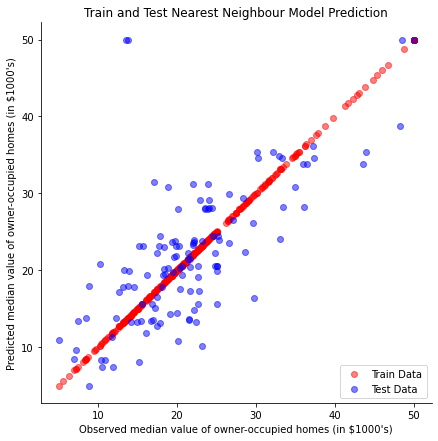

In [31]:
#Plotting
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()

ax.scatter(bdata_train['MEDV'], train_NN_Predicted, c='red', label='Train Data', alpha=0.5)
ax.scatter(bdata_test['MEDV'], test_NN_Predicted, c='blue', label='Test Data', alpha=0.5)

ax.set_xlabel("Observed median value of owner-occupied homes (in $1000's)")
ax.set_ylabel("Predicted median value of owner-occupied homes (in $1000's)")
ax.set_title("Train and Test Nearest Neighbour Model Prediction")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show(fig)

* Train Results:
    * Time taken: 0.03 seconds
    * Nearest Neighbour 
    * Train RMSE: 0.0

* Test Results:
    * Time taken: 0.01 seconds
    * Nearest Neighbour
    * Test RMSE: 6.894908404377965

* Comparing with result in 1.3, Test RMSE has decreased a little from 8.89 to 6.89. In terms of runtime, it took around 0.01 seconds as compared to Zero second for baseline 

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the standardized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using `CRIM, RM and ZN` as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, you should compute the mean and standard deviation on the training set, and use the same values to normalize both the training and the testing dataset.

*NOTE 2*: In this case, the normalization may or may not reduce the RMSE; don't get confused if you find that to be the case.

In [15]:
"""
Function
--------
Normalize data

Normalize all of the features in a data frame.

Parameters
----------
raw_data: array
    Array of numerical values to normalize.

Returns
-------
normalized_data : array
    The array with normalized values for all features
"""
def normalize(raw_data):
    
    normalized_data= (raw_data - np.mean(raw_data))/np.std(raw_data)
        
    return normalized_data


bdata_train_normalized = bdata_train.copy()
for col in bdata_train.columns:
    if col!='MEDV':
        bdata_train_normalized[col] = normalize(bdata_train[col])
    
bdata_test_normalized = bdata_test.copy()
for col in bdata_test.columns:
    if col!='MEDV':
        bdata_test_normalized[col] = normalize(bdata_test[col])

In [16]:
#Computing RMSE based on normalized data using nearest neighbour

print("Train Results:")
#Train RMSE
train_NN_Predicted_normalized, train_NN_RMSE_normalized,train_NN_t_normalized = nneighbor(bdata_train_normalized[['CRIM','RM','ZN']].values,bdata_train_normalized['MEDV'].values,
                                                bdata_train_normalized[['CRIM','RM','ZN']].values,bdata_train_normalized['MEDV'].values, 2)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE_normalized)

print()
print("Test Results:")
#Test RMSE
test_NN_Predicted_normalized, test_NN_RMSE_normalized, test_NN_t_normalized = nneighbor(bdata_train_normalized[['CRIM','RM','ZN']].values,bdata_train_normalized['MEDV'].values,
                                                       bdata_test_normalized[['CRIM','RM','ZN']].values,bdata_test_normalized['MEDV'].values,2)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE_normalized)

Train Results:
Time taken: 0.02 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.01 seconds
Nearest Neighbour: Test RMSE
7.9


RMSE for normalized test data: 7.89 ~ 7.9
previous RMSE of test data: 6.89

As we can see, the RSME for the normalised test data is 1 unit bigger than the previous RSME

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L! Use the test set to report the RMSE values.

What combination of features and distance function provide the lowest RMSE on the test set?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features. 

In [32]:
#Trying models with features: LSTAT and CHAS with L=5

#Computing RMSE based on normalized data using nearest neighbour

print("Train Results:")
#Train RMSE
train_NN_Predicted_normalized, train_NN_RMSE_normalized,train_NN_t_normalized = nneighbor(bdata_train_normalized[['LSTAT','CHAS']].values,bdata_train_normalized['MEDV'].values,
                                                bdata_train_normalized[['LSTAT','CHAS']].values,bdata_train_normalized['MEDV'].values, 5)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE_normalized)

print()
print("Test Results:")
#Test RMSE
test_NN_Predicted_normalized, test_NN_RMSE_normalized, test_NN_t_normalized = nneighbor(bdata_train_normalized[['LSTAT','CHAS']].values,bdata_train_normalized['MEDV'].values,
                                                       bdata_test_normalized[['LSTAT','CHAS']].values,bdata_test_normalized['MEDV'].values,5)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE_normalized)

Train Results:
Time taken: 0.02 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.01 seconds
Nearest Neighbour: Test RMSE
6.39


In [33]:
#Trying models with features: PTRATIO and NOX with L=6

#Computing RMSE based on normalized data using nearest neighbour

print("Train Results:")
#Train RMSE
train_NN_Predicted_normalized, train_NN_RMSE_normalized,train_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','NOX']].values,bdata_train_normalized['MEDV'].values,
                                                bdata_train_normalized[['PTRATIO','NOX']].values,bdata_train_normalized['MEDV'].values, 6)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE_normalized)

print()
print("Test Results:")
#Test RMSE
test_NN_Predicted_normalized, test_NN_RMSE_normalized, test_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','NOX']].values,bdata_train_normalized['MEDV'].values,
                                                       bdata_test_normalized[['PTRATIO','NOX']].values,bdata_test_normalized['MEDV'].values,6)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE_normalized)

Train Results:
Time taken: 0.03 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.01 seconds
Nearest Neighbour: Test RMSE
10.9


In [34]:
#Trying models with features: PTRATIO and LSTAT with L=4

#Computing RMSE based on normalized data using nearest neighbour

print("Train Results:")
#Train RMSE
train_NN_Predicted_normalized, train_NN_RMSE_normalized,train_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','LSTAT']].values,bdata_train_normalized['MEDV'].values,
                                                bdata_train_normalized[['PTRATIO','LSTAT']].values,bdata_train_normalized['MEDV'].values, 4)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE_normalized)

print()
print("Test Results:")
#Test RMSE
test_NN_Predicted_normalized, test_NN_RMSE_normalized, test_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','LSTAT']].values,bdata_train_normalized['MEDV'].values,
                                                       bdata_test_normalized[['PTRATIO','LSTAT']].values,bdata_test_normalized['MEDV'].values,4)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE_normalized)

Train Results:
Time taken: 0.03 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.01 seconds
Nearest Neighbour: Test RMSE
6.6


In [20]:
#Trying models with features: PTRATIO,CRIM, NOX, AGE and LSTAT with L=4

#Computing RMSE based on normalized data using nearest neighbour

print("Train Results:")
#Train RMSE
train_NN_Predicted_normalized, train_NN_RMSE_normalized,train_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_train_normalized['MEDV'].values,
                                                bdata_train_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_train_normalized['MEDV'].values, 4)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE_normalized)

print()
print("Test Results:")
#Test RMSE
test_NN_Predicted_normalized, test_NN_RMSE_normalized, test_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_train_normalized['MEDV'].values,
                                                       bdata_test_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_test_normalized['MEDV'].values,4)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE_normalized)

Train Results:
Time taken: 0.05 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.01 seconds
Nearest Neighbour: Test RMSE
7.05


In [21]:
#Trying models with features: PTRATIO,CRIM, NOX, AGE and LSTAT with L=6

#Computing RMSE based on normalized data using nearest neighbour

print("Train Results:")
#Train RMSE
train_NN_Predicted_normalized, train_NN_RMSE_normalized,train_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_train_normalized['MEDV'].values,
                                                bdata_train_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_train_normalized['MEDV'].values, 6)

print("Nearest Neighbour: Train RMSE")
print(train_NN_RMSE_normalized)

print()
print("Test Results:")
#Test RMSE
test_NN_Predicted_normalized, test_NN_RMSE_normalized, test_NN_t_normalized = nneighbor(bdata_train_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_train_normalized['MEDV'].values,
                                                       bdata_test_normalized[['PTRATIO','LSTAT','CRIM','NOX','AGE']].values,bdata_test_normalized['MEDV'].values,6)
print("Nearest Neighbour: Test RMSE")
print(test_NN_RMSE_normalized)

Train Results:
Time taken: 0.06 seconds
Nearest Neighbour: Train RMSE
0.0

Test Results:
Time taken: 0.02 seconds
Nearest Neighbour: Test RMSE
6.92


* For me, the following combination of features worked the best, giving the smallest RMSE: **LSTAT and CHAS with L=5** getting 6.39
* Comparing the time taken by all the model, yes, choice of decisions do affect the runtime of the algorithm. 

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 25-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with `CRIM,RM and ZN` input features, as well as the total running time for the full run of 25 folds.  In other words, randomly divide your training dataset (created in 1.2) into 25 equally-sized samples.

For each of the 25 iterations (the "folds"), use 24 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for validation.  Compute the RMSE of that particular validation set, then move on to the next iteration.  

 - Report the average cross-validated RMSE across the 25 iterations. What do you observe?
 
 - Create a histogram of the RMSEs for the folds (there should be 25 of these). Additionally, use a horizontal line to mark the average cross-validated RMSE.


[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation



NOTE: To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

HINT: Running 25-fold cross validation might be time-consuming. Try starting with 5 folds.

In [22]:
np.random.seed(seed=13579)

# Using full original dataset for cross validation

# Length of each fold
len_fold = np.int(len(boston_data)/25)

# Randomly select folds
fold_index = np.random.choice(range(len(boston_data)), (25, len_fold), replace=False)

# Assign the folds
for i in range(25):
    boston_data.loc[fold_index[i], 'fold'] = i+1

# Initialize vector for storing each iteration result
RMSE_cv = np.zeros(25)
t_cv = np.zeros(25)

#Iteration
for i in range(25):
    bdata_train_fold = boston_data[boston_data['fold'] != (i+1)]
    bdata_test_fold =  boston_data[boston_data['fold'] == (i+1)]
    
    #Normalizing the train and test set for each iteration
    bdata_train_fold_norm = bdata_train_fold.copy()
    for col in bdata_train_fold.columns:
        if col!='MEDV':
            bdata_train_fold_norm[col] = normalize(bdata_train_fold[col])
    
    bdata_test_fold_norm = bdata_test_fold.copy()
    for col in bdata_test_fold.columns:
        if col!='MEDV':
            bdata_test_fold_norm[col] = normalize(bdata_test_fold[col])
    
    #Test RMSE
    predicted, rmse, t = nneighbor(bdata_train_fold_norm[['CRIM','RM','ZN']].values,bdata_train_fold_norm['MEDV'].values,
                                    bdata_test_fold_norm[['CRIM','RM','ZN']].values,bdata_test_fold_norm['MEDV'].values,2)
    
    RMSE_cv[i] = rmse
    t_cv[i] = t

RMSE_cv = pd.DataFrame(RMSE_cv,columns=['RMSE'])
RMSE_cv

Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds
Time taken: 0.00 seconds


,RMSE
0,6.47
1,6.34
2,5.93
3,5.42
4,4.81
5,5.81
6,8.93
7,9.16
8,3.49
9,14.65


In [23]:
#Average RMSE
np.mean(RMSE_cv.RMSE)

7.788400000000001

In [24]:
#Total runtime for prediction
sum(t_cv)

0.032213449478149414

* Average RMSE: 7.789
* Total Runtime (Prediction): 0.027 seconds

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Use 10-fold cross validation and L2 normalization, and the same features as in 2.5. Report the RMSE for K=5 and the running time of the algorithm. What do you observe?

In [25]:
"""
Function
--------
K-Nearest Neighbors

Implementation of nearest neighbors algorithm.

Parameters
----------
x_train: array
    Array of numerical feature values for training the model.
y_train: array
    Array of numerical output values for training the model.
x_test: array
    Array of numerical feature values for testing the model.
y_test: array
    Array of numerical output values for testing the model.
L: int
    Order of L-norm function used for calculating distance.
K: int
    Neighbors to include in algorithm
    
Returns
-------
rmse : int
    Value of the RMSE from data.
"""

def knn(X,Y,fold_num, L, K):
    # start the watch
    t_start = time.time()
    
    #Storing vector for RMSE for 10 folds
    rmse_folds = np.zeros(10)
    
    # Iterating through the folds
    for i in range(10):   
        #Train and Test for each fold 
        X_train = X[fold_num!=(i+1)]
        Y_train = Y[fold_num!=(i+1)]
        X_test = X[fold_num==(i+1)]
        Y_test = Y[fold_num==(i+1)]
        
        # initiate the storage vector
        Y_test_predicted = np.zeros(len(X_test))
        
        # Predicting the median house value
        for j in range(len(X_test)):
            # calculate distance
            dist = distance(X_test[j], X_train, L)
            # calculate the mean Y of the K nearest points
            Y_test_predicted[j] = np.mean(Y_train[dist.argsort()[:K]])
            
        # RMSE
        rmse_folds[i] = compute_rmse(Y_test_predicted, Y_test)
        
    t = time.time() - t_start
    rmse = np.mean(rmse_folds)    
    
    return rmse,t

#Normalizing complete dataset 
boston_data_norm = boston_data.copy()
for col in boston_data.columns:
    if (col!='MEDV') & (col!= 'fold'):
        boston_data_norm[col] = normalize(boston_data[col])

rmse, t = knn(boston_data_norm[['CRIM','RM','ZN']].values,boston_data_norm['MEDV'].values,boston_data_norm['fold'].values, 2, 5)

print("RMSE:")
print(rmse)
print()
print("Time taken:")
print(t)

RMSE:
4.246

Time taken:
0.022574186325073242


RMSE:
4.244805451214061

Time taken:
0.030987024307250977

### 2.7 Using cross validation to find K

Compute the cross-validated RMSE for values of K between 1 and 25 using 10-fold cross-validation and L2 normalization.  Use the following features in your model: `CRIM, ZN, RM, AGE, DIS, TAX`.  Create a graph that shows how cross-validated RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

Finally, report the test RMSE using the value of K that minimized the cross-validated RMSE. (Continue to use L2 normalization and the same set of features). How does the test RMSE compare to the cross-validated RMSE, and is this what you expected? How does the test RMSE compare to the test RMSE from 2.4, and is this what you expected?

In [26]:
rmse_K = np.zeros(25)

for i in range(25):
    rmse, t = knn(boston_data_norm[['CRIM','ZN','RM','AGE','DIS','TAX']].values,
                  boston_data_norm['MEDV'].values,
                  boston_data_norm['fold'].values, 2, i+1)
    rmse_K[i] = rmse
    
rmse_K = pd.DataFrame(rmse_K,columns=['RMSE'])
rmse_K.index.name = 'K'
rmse_K=rmse_K.reset_index()
rmse_K['K'] = rmse_K['K'] + 1
rmse_K.sort_values("RMSE")

,K,RMSE
5,6,3.535
6,7,3.537
7,8,3.545
4,5,3.614
8,9,3.689
9,10,3.735
3,4,3.759
2,3,3.791
11,12,3.806
10,11,3.813


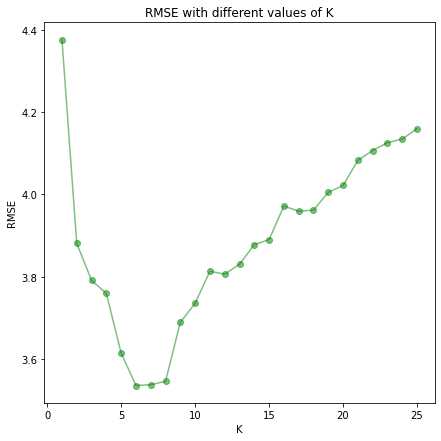

In [27]:
#Plotting
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()

ax.plot(rmse_K['K'], rmse_K['RMSE'],marker='o', c='green', alpha=0.5)

ax.set_xlabel("K")
ax.set_ylabel("RMSE")
ax.set_title("RMSE with different values of K");

* Best choice of K for this data is 6.
* As one can see in the graph, the RMSE decreases intitally with increase in the value of K, but after a point (K=6), it starts increasing again.

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](https://see.stanford.edu/materials/aimlcs229/cs229-notes5.pdf) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

In [28]:
#Forward Selection
# Using K= 6 as found optimal in 2.7 above

# Lsist of features
all_feature_list = boston_data_norm.columns[0:13]

#Number of features available 
num_features= len(all_feature_list)
feature_RMSE = np.zeros(num_features)
feature_list = []

#Iteration on the total number of features
for i in range(num_features):
    test_RMSE=[]
    test_feature_list = []
    
    for j in range(num_features):
        if all_feature_list[j] not in feature_list:
            test_features = copy.deepcopy(feature_list)
            test_features.append(all_feature_list[j])
            rmse, t = knn(boston_data_norm[test_features].values,
                  boston_data_norm['MEDV'].values,
                  boston_data_norm['fold'].values, 2, 6)
            test_RMSE.append(rmse)
            test_feature_list.append(all_feature_list[j])
    
    min_RMSE = np.argmin(test_RMSE)
    feature_RMSE[i] = test_RMSE[min_RMSE]
    feature_list.append(test_feature_list[min_RMSE])

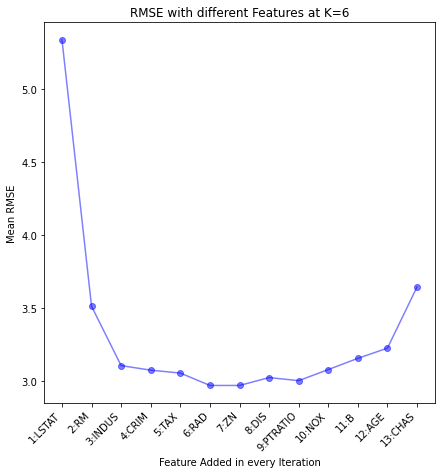

In [29]:
#Plotting
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()

ax.plot(np.arange(num_features), feature_RMSE,marker='o', c='blue', alpha=0.5)

#X-tick labels
x_tick_labels = []
for i in range(num_features):
    x_tick_labels.append('{}:{}'.format(i+1, feature_list[i]))
                         
ax.set_xlabel("Feature Added in every Iteration")
ax.set_xticks(np.arange(num_features))
ax.set_xticklabels(x_tick_labels,rotation=45, ha='right')
ax.set_ylabel("Mean RMSE")
ax.set_title("RMSE with different Features at K=6");